In [62]:
# Important settings to get pos_base or base model
USE_POS = True  # decide whether preprocessing data with POS in the sentences or not
ADAPTIVE_TRUNCATION = True  # if True, set truncation_lenght to 95th quantile of train max lenght else just use 256

# Paths to retrieve data
DATASET_PATH  = "Augmented Datasets/"
FEVER_PLUS_PATH = 'tommasobonomo/sem_augmented_fever_nli'
ADVERSARIAL_FEVER_PATH = "iperbole/adversarial_fever_nli" #'https://huggingface.co/datasets/iperbole/adversarial_fever_nli'

# Base Model

In [59]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}...')

Using cuda...


In [61]:
# free up CUDA space and optimize space used
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.95, 0)  # Use 95% of GPU memory
#torch.cuda.set_max_split_size_mb(256)  # Set max split size to 256MB


### Loading and analyzing data

In [60]:
from datasets import load_dataset
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

fever_plus = load_dataset("tommasobonomo/sem_augmented_fever_nli")

# Load the DeBERTa tokenizer 
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-xsmall')


c:\Users\damic\anaconda3\envs\nlp_env2\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [54]:
import numpy as np

# this function is used ONLY for POS tagging version of the model;
# base model w/o POS is just set to 256, which is enough
def compute_lengths(dataset, tokenizer):
    lengths = []
    for entry in dataset:
        premise = entry["premise"]
        hypothesis = entry["hypothesis"]
        
        premise_with_pos = f"{premise} POS: {' '.join([wsd['pos'] for wsd in entry['wsd']['premise']])}"
        hypothesis_with_pos = f"{hypothesis} POS: {' '.join([wsd['pos'] for wsd in entry['wsd']['hypothesis']])}"
        
        combined_input = f"[CLS] {premise_with_pos} [SEP] {hypothesis_with_pos}"
        encoding = tokenizer(combined_input, truncation=False, padding=False)
        
        lengths.append(len(encoding['input_ids']))
    

    return lengths


# Analyze the distribution of lengths (of train dataset)
lengths = compute_lengths(fever_plus['train'], tokenizer)
length = np.array(lengths)
mean_length = np.mean(lengths)
percentile_length = np.percentile(lengths, 95)
max_length = np.max(lengths)

# Print lenghts to show distribution
print(f"Mean length: {mean_length}")
print(f"95th percentile length: {percentile_length}")
print(f"Max length: {max_length}")

# POS lenghts are: 
# mean: 210, 95th: 438, max: 3728

Mean length: 210.36996437380105
95th percentile length: 438.0
Max length: 3728


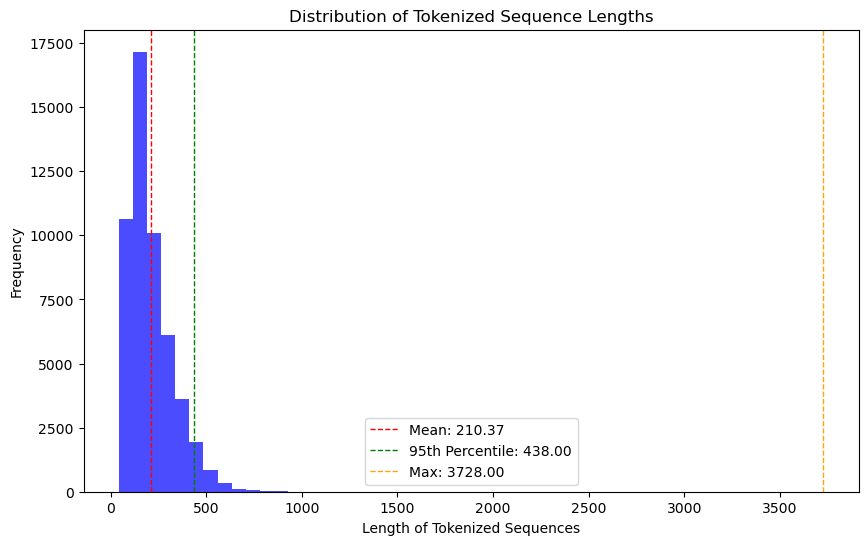

In [55]:
import matplotlib.pyplot as plt
# Plot the distribution of lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(percentile_length, color='green', linestyle='dashed', linewidth=1, label=f'95th Percentile: {percentile_length:.2f}')
plt.axvline(max_length, color='orange', linestyle='dashed', linewidth=1, label=f'Max: {max_length:.2f}')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.xlabel('Length of Tokenized Sequences')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Data preprocessing

In [65]:
# combine the elements from a fever entry to prepare a feasible input for 
def preprocess_input(entry, tokenizer, truncation_length=128, use_POS=True):

    # Sample premise and hypothesis with POS tagging
    premise = entry["premise"]
    hypothesis = entry["hypothesis"]

    if use_POS:
        # Corresponding POS tags (this is just a placeholder for the actual POS tags)
        premise_pos = " ".join([wsd['pos'] for wsd in entry["wsd"]["premise"]])             # create a sentence with the list of all the POS tags sepaated by space
        hypothesis_pos = " ".join([wsd['pos'] for wsd in entry["wsd"]["hypothesis"]])       # 

        # Combine text with POS tags
        premise_with_pos = f"{premise} POS: {premise_pos}"
        hypothesis_with_pos = f"{hypothesis} POS: {hypothesis_pos}"
        
        # Prepare the combined input for the model
        combined_input = f"[CLS] {premise_with_pos} [SEP] {hypothesis_with_pos}"
        encoding = tokenizer(combined_input, truncation=True, padding='max_length', max_length=truncation_length)
    
    else:
        combined_input = f"[CLS] {premise} [SEP] {hypothesis}"
        encoding = tokenizer(combined_input, truncation=True, padding='max_length', max_length=truncation_length)

    # Map labels as integers representing the classes
    label_map = {'ENTAILMENT': 0, 'CONTRADICTION': 1, 'NEUTRAL': 2}
    int_label = label_map[entry['label']]


    return {**encoding, 'label': int_label}


In [66]:
import torch
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

# Set truncation length as desired
truncation_length = int(percentile_length) if ADAPTIVE_TRUNCATION else 256
print(f'Truncation length set at {truncation_length}')

# Apply preprocessing to datasets
train_dataset = fever_plus['train'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'truncation_length' : truncation_length, 'use_POS':USE_POS})
val_dataset = fever_plus['validation'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'truncation_length' : truncation_length, 'use_POS':USE_POS})
test_dataset = fever_plus['test'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'truncation_length' : truncation_length, 'use_POS':USE_POS})

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Truncation length set at 438


Map: 100%|██████████| 2287/2287 [00:08<00:00, 258.65 examples/s]


### Model training

In [9]:
# TRAINING!!


# Load the DeBerta v3 model
model = DebertaV2ForSequenceClassification.from_pretrained('microsoft/deberta-v3-xsmall', num_labels=3)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,  # Simulate batch size of 8*4=32 but without loading all at once
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,                       # Mixed precision training (weight are in float16)
    no_cuda=False  # Use CPU instead of GPU
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Evaluate the model
#trainer.evaluate()


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\anon\miniconda3\envs\nlp\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\anon\miniconda3\envs\nlp\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  6%|▋         | 500/7980 [1:17:36<19:12:51,  9.25s/it]

{'loss': 0.647, 'grad_norm': 5.158054828643799, 'learning_rate': 1.87468671679198e-05, 'epoch': 0.31}


 13%|█▎        | 1000/7980 [2:34:44<17:55:46,  9.25s/it]

{'loss': 0.449, 'grad_norm': 4.427201747894287, 'learning_rate': 1.749624060150376e-05, 'epoch': 0.63}


 19%|█▉        | 1500/7980 [3:51:52<16:39:55,  9.26s/it]

{'loss': 0.4251, 'grad_norm': 2.7518105506896973, 'learning_rate': 1.624561403508772e-05, 'epoch': 0.94}


                                                        
 20%|██        | 1596/7980 [4:11:19<16:25:05,  9.26s/it]

{'eval_loss': 0.7372671365737915, 'eval_runtime': 273.4881, 'eval_samples_per_second': 8.366, 'eval_steps_per_second': 8.366, 'epoch': 1.0}


 25%|██▌       | 2000/7980 [5:14:01<15:26:37,  9.30s/it] 

{'loss': 0.3759, 'grad_norm': 4.1460795402526855, 'learning_rate': 1.4992481203007521e-05, 'epoch': 1.25}


 31%|███▏      | 2500/7980 [6:31:35<14:09:18,  9.30s/it]

{'loss': 0.3708, 'grad_norm': 3.2597908973693848, 'learning_rate': 1.3739348370927319e-05, 'epoch': 1.57}


 38%|███▊      | 3000/7980 [7:49:21<12:53:28,  9.32s/it]

{'loss': 0.3564, 'grad_norm': 2.9030721187591553, 'learning_rate': 1.248621553884712e-05, 'epoch': 1.88}


                                                        
 40%|████      | 3193/7980 [8:23:57<12:13:32,  9.19s/it]

{'eval_loss': 0.7466031312942505, 'eval_runtime': 273.5547, 'eval_samples_per_second': 8.364, 'eval_steps_per_second': 8.364, 'epoch': 2.0}


 44%|████▍     | 3500/7980 [9:37:43<18:04:01, 14.52s/it] 

{'loss': 0.3352, 'grad_norm': 4.200982570648193, 'learning_rate': 1.1233082706766919e-05, 'epoch': 2.19}


 50%|█████     | 4000/7980 [11:38:17<15:56:43, 14.42s/it]

{'loss': 0.3181, 'grad_norm': 4.335425853729248, 'learning_rate': 9.979949874686718e-06, 'epoch': 2.51}


 56%|█████▋    | 4500/7980 [13:38:40<13:54:48, 14.39s/it]

{'loss': 0.319, 'grad_norm': 4.557716369628906, 'learning_rate': 8.726817042606517e-06, 'epoch': 2.82}


                                                         
 60%|██████    | 4789/7980 [14:43:17<8:09:33,  9.21s/it]

{'eval_loss': 0.713811457157135, 'eval_runtime': 273.3697, 'eval_samples_per_second': 8.37, 'eval_steps_per_second': 8.37, 'epoch': 3.0}


 63%|██████▎   | 5000/7980 [15:32:39<11:54:38, 14.39s/it]

{'loss': 0.2992, 'grad_norm': 7.325547218322754, 'learning_rate': 7.473684210526316e-06, 'epoch': 3.13}


 69%|██████▉   | 5500/7980 [17:33:04<9:54:38, 14.39s/it] 

{'loss': 0.2854, 'grad_norm': 6.902440071105957, 'learning_rate': 6.223057644110277e-06, 'epoch': 3.45}


 75%|███████▌  | 6000/7980 [19:33:28<7:54:54, 14.39s/it] 

{'loss': 0.2923, 'grad_norm': 3.465545177459717, 'learning_rate': 4.969924812030076e-06, 'epoch': 3.76}


                                                        
 80%|████████  | 6386/7980 [21:13:30<6:15:58, 14.15s/it]

{'eval_loss': 0.7740113139152527, 'eval_runtime': 425.5744, 'eval_samples_per_second': 5.376, 'eval_steps_per_second': 5.376, 'epoch': 4.0}


 81%|████████▏ | 6500/7980 [21:40:55<5:57:22, 14.49s/it]  

{'loss': 0.273, 'grad_norm': 4.418797969818115, 'learning_rate': 3.7167919799498746e-06, 'epoch': 4.07}


 88%|████████▊ | 7000/7980 [23:41:21<3:57:42, 14.55s/it]

{'loss': 0.2629, 'grad_norm': 10.50509262084961, 'learning_rate': 2.4636591478696745e-06, 'epoch': 4.38}


 94%|█████████▍| 7500/7980 [25:31:36<1:13:33,  9.19s/it]

{'loss': 0.2649, 'grad_norm': 4.186285495758057, 'learning_rate': 1.2130325814536342e-06, 'epoch': 4.7}


                                                        
100%|██████████| 7980/7980 [26:49:46<00:00, 12.10s/it]

{'eval_loss': 0.7918862104415894, 'eval_runtime': 273.2713, 'eval_samples_per_second': 8.373, 'eval_steps_per_second': 8.373, 'epoch': 5.0}
{'train_runtime': 96586.7412, 'train_samples_per_second': 2.645, 'train_steps_per_second': 0.083, 'train_loss': 0.34633619361055223, 'epoch': 5.0}


TrainOutput(global_step=7980, training_loss=0.34633619361055223, metrics={'train_runtime': 96586.7412, 'train_samples_per_second': 2.645, 'train_steps_per_second': 0.083, 'total_flos': 1.4390385496304544e+16, 'train_loss': 0.34633619361055223, 'epoch': 4.998434074538052})

In [10]:
# Save model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\spm.model',
 './saved_model\\added_tokens.json')

### Model testing

In [82]:
# # OPTIONAL: Load from file the model if you don't want to train again

# from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
# model_path = 'models/pos_base_model/saved_model'
# # Load the saved model and tokenizer
# model = AutoModelForSequenceClassification.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# # Initialize the Trainer
# trainer = Trainer(
#     model=model,
#     train_dataset=None,
#     eval_dataset=None,
# )

c:\Users\damic\anaconda3\envs\nlp_env2\lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


100%|██████████| 286/286 [01:44<00:00,  2.73it/s]


F1 Score on the test set: 0.7314639055348242


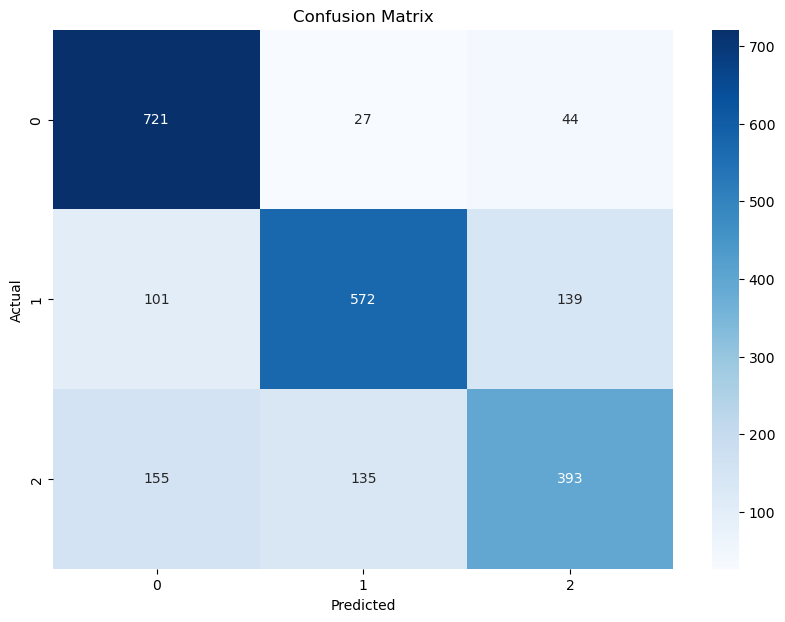

Confusion matrix saved to ./results/confusion_matrix.png


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")


In [84]:
adv_test_data = load_dataset(ADVERSARIAL_FEVER_PATH)['test'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})

# Apply preprocessing to datasets
adv_test_dataset = adv_test_data.map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'truncation_length' : truncation_length, 'use_POS':False})

# Set format for PyTorch
adv_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 337/337 [00:00<00:00, 876.16 examples/s] 


100%|██████████| 43/43 [00:15<00:00,  2.81it/s]


F1 Score on the test set: 0.44685491181296993


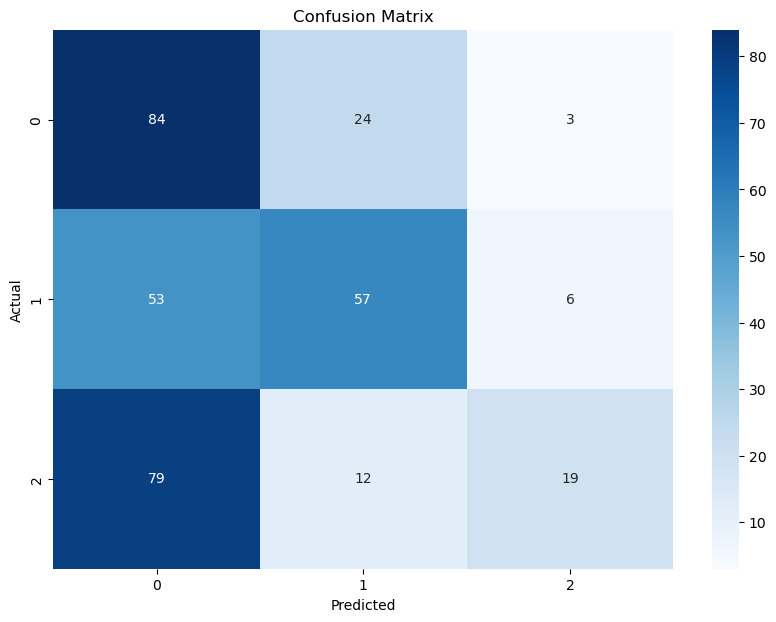

Confusion matrix saved to ./results/adv_confusion_matrix.png


In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(adv_test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/adv_confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/adv_confusion_matrix.png")


In [86]:
# Ensure all jsonl files for augmented datasets are here
import os
import zipfile

# Datasets needed:
file_paths = [
    DATASET_PATH+"fever_train_wr",
    DATASET_PATH+"fever_validation_wr",
    DATASET_PATH+"fever_test_wr",
    DATASET_PATH+"fever_train_syn",
    DATASET_PATH+"fever_validation_syn",
    DATASET_PATH+"fever_test_syn"
]


for path in file_paths:
    if not os.path.exists(path+'.jsonl'):
        # Unzip if not exist already
        with zipfile.ZipFile(path+'.zip', 'r') as zip:
            zip.extractall(DATASET_PATH)
            print(f"{path} extracted to {DATASET_PATH}")


# load and assemble datasets
from datasets import Dataset
import json
import pandas as pd

# Function to load .jsonl dataset
def load_jsonl_datasets(premise_file_path, hypothesis_file_path):
    #data = {'premise' [], 'hypothesis' [], 'label' []}
    premises = []
    hypotheses = []
    labels = []

    # Load premise and labels
    with open(premise_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            premises.append(entry['augmented_premise'])
            labels.append(entry['label'])

    # Load hypothesis
    with open(hypothesis_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            hypotheses.append(entry['augmented_hypothesis'])

    # wr_data = pd.read_json(premise_file_path, lines=True)
    # syn_data = pd.read_json(hypothesis_file_path, lines=True)

    # Convert to Hugging Face Dataset
    data = {'premise': premises, 'hypothesis': hypotheses, 'label': labels}
    #data = {'premise' wr_data['augmented_premise'], 'hypothesis' syn_data['augmented_hypothesis'], 'label' syn_data['label']}
    return Dataset.from_dict(data)


# Load datasets from jsonl files
augmented_test_data = load_jsonl_datasets(DATASET_PATH+'fever_test_wr.jsonl', DATASET_PATH+'fever_test_syn.jsonl')

# Apply preprocessing to datasets
augmented_test_dataset = augmented_test_data.map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'truncation_length' : truncation_length, 'use_POS':False})

# Set format for PyTorch
augmented_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map: 100%|██████████| 2287/2287 [00:42<00:00, 53.41 examples/s]


100%|██████████| 286/286 [01:43<00:00,  2.75it/s]


F1 Score on the test set: 0.2887316576362037


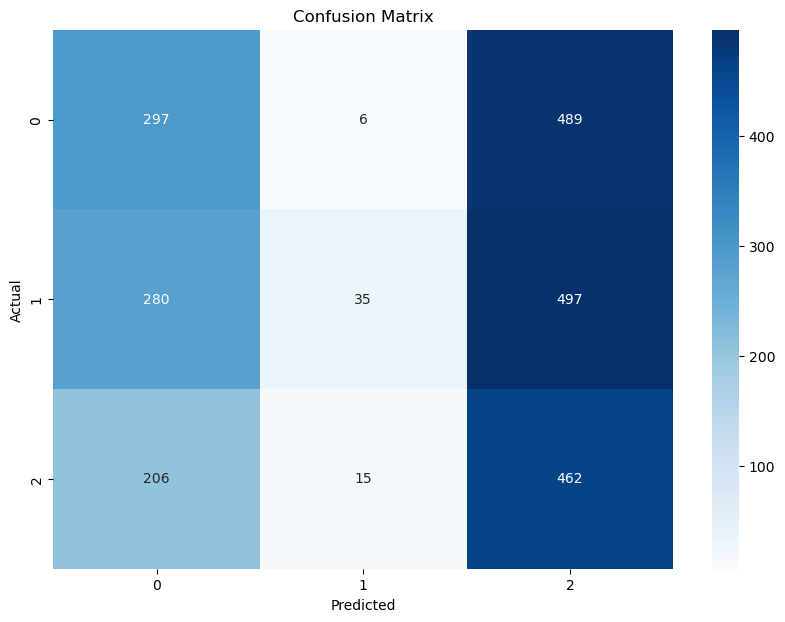

Confusion matrix saved to ./results/adv_confusion_matrix.png


In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(augmented_test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/adv_confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/adv_confusion_matrix.png")
